## This notebook will hold the model iterations with the balanced dataset (added more images to the validation file)

In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=BadKey)

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import glob
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat, target_names=['NORMAL', 'PNEUMONIA']))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [4]:
def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

### Group parameters for train and test data generators the entire group is using for this project

In [69]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data = train_datagen.flow_from_directory('../data/bal_chest_xray/train/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
val_data = val_datagen.flow_from_directory('../data/bal_chest_xray/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
test_data = test_datagen.flow_from_directory('../data/bal_chest_xray/test//',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary',
                                             color_mode='grayscale')

Found 4684 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Function to show the chest xray images

In [6]:
train_images, train_labels = next(iter(train_data))
train_img = train_images.reshape(train_images.shape[0], -1)

def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

### Metrics we will be evaluated our models on

In [7]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

### Model iteration with balanced validation set

In [22]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=110, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(train_data, epochs=30, validation_data=(val_data))

In [13]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 4s 195ms/step - loss: 0.4687 - accuracy: 0.8574 - precision: 0.8293 - recall: 0.9718


[('loss', 0.46865418553352356),
 ('accuracy', 0.8573718070983887),
 ('precision', 0.8293216824531555),
 ('recall', 0.971794843673706)]

In [8]:
first_batch = test_data.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]
while batch_index <= test_data.batch_index:
    data = test_data.next()
    #print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array = np.asarray(data_list)
data_array.shape

(624, 100, 100, 1)

In [15]:
preds = model.predict_classes(data_array)

              precision    recall  f1-score   support

      NORMAL       0.93      0.67      0.78       234
   PNEUMONIA       0.83      0.97      0.89       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624

Accurancy:  0.8573717948717948


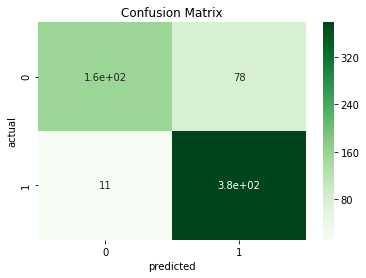

In [16]:
evaluation(class_list, preds)

#### Achieving an accuracy score of .88 on the hold out test data was better than we expected for a baseline model. I am going to try adding a batch normalization layer.

In [12]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
#Batch Normalization Layer
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=110, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(train_data, epochs=30,  validation_data=(val_data))

Epoch 1/30
163/163 [==============================] - 52s 317ms/step - loss: 0.5674 - accuracy: 0.8898 - precision: 0.9253 - recall: 0.9265 - val_loss: 0.5608 - val_accuracy: 0.7917 - val_precision: 0.7619 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 51s 310ms/step - loss: 0.1637 - accuracy: 0.9339 - precision: 0.9554 - recall: 0.9556 - val_loss: 0.4454 - val_accuracy: 0.8750 - val_precision: 0.8421 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 50s 310ms/step - loss: 0.1606 - accuracy: 0.9396 - precision: 0.9597 - recall: 0.9590 - val_loss: 0.7883 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 50s 309ms/step - loss: 0.1441 - accuracy: 0.9425 - precision: 0.9599 - recall: 0.9628 - val_loss: 0.2591 - val_accuracy: 0.8333 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/30
163/163 [==============================] - 50s 309ms/step - loss: 0.1330 - accura

              precision    recall  f1-score   support

      NORMAL       0.84      0.88      0.86       234
   PNEUMONIA       0.93      0.90      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.88       624
weighted avg       0.89      0.89      0.89       624

Accurancy:  0.8910256410256411


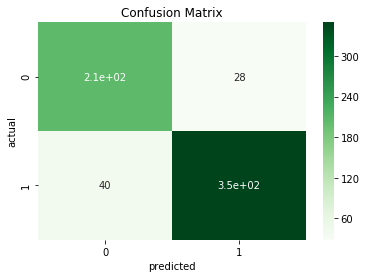

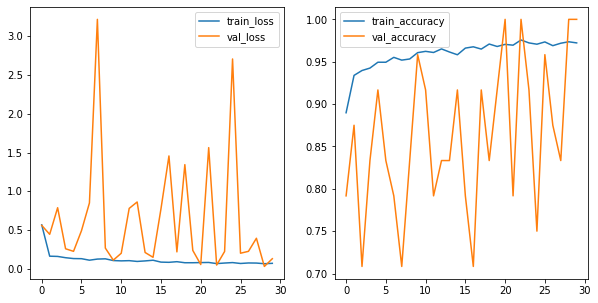

In [18]:
preds2 = model.predict_classes(data_array)
evaluation(class_list, preds2)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

In [19]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 3s 166ms/step - loss: 0.4264 - accuracy: 0.8910 - precision: 0.9259 - recall: 0.8974


[('loss', 0.42642614245414734),
 ('accuracy', 0.8910256624221802),
 ('precision', 0.9259259104728699),
 ('recall', 0.8974359035491943)]

              precision    recall  f1-score   support

      NORMAL       0.91      0.78      0.84       234
   PNEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Accurancy:  0.8894230769230769


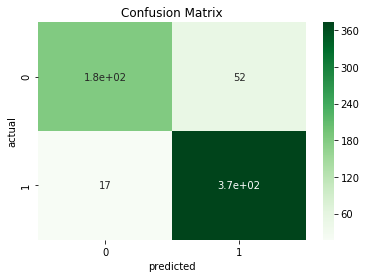

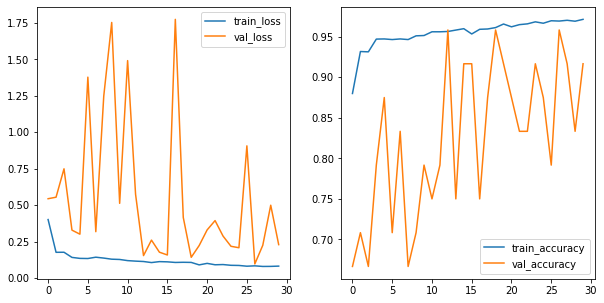

In [49]:
preds2 = model.predict_classes(data_array)
evaluation(class_l ist, preds2)

train_loss = model.history.history['loss']
train_acc = model.history.history['accuracy']
val_loss = model.history.history['val_loss']
val_acc = model.history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

In [50]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 5s 239ms/step


[('loss', 0.3413003087043762),
 ('accuracy', 0.8894230723381042),
 ('precision', 0.9691228866577148),
 ('recall', 0.9690080881118774)]

In [120]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=4242d50ca9d5f223b7d6a501777148b0c1bb1d860abd8762b024b83700bbe6db
  Stored in directory: /Users/JasonWong/Library/Caches/pip/wheels/9c/e1/ab/1b35bf1600303ed3255d015ed61d064132e163386a94045081
Successfully built keras-resnet
Note: you may need to restart the kernel to use updated packages.


### The cells below are an unsuccessful attempt at preprocessing the images

In [119]:
transfer_train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
transfer_val_datagen = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                    rescale=1./225)
transfer_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = transfer_train_datagen.flow_from_directory('data/chest_xray/train/')
                                               #target_size=(224,224),
                                               #batch_size=32,
                                               #class_mode='binary',
                                               #color_mode='grayscale')
transfer_val_data = transfer_val_datagen.flow_from_directory('data/chest_xray/val/')
                                               #target_size=(224,224),
                                               #batch_size=32,
                                               #class_mode='binary',
                                               #color_mode='grayscale')
transfer_test_data = transfer_test_datagen.flow_from_directory('data/chest_xray/test//')
                                             #target_size=(224,224),
                                             #batch_size=32,
                                             #class_mode='binary',
                                             #color_mode='grayscale')

Found 5217 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Converting train images to RGB

In [42]:
batch_3 = train_data.next()
data_list = batch_3[0]
batch_index = 0
class_list = batch_3[1]
while batch_index <= train_data.batch_index:
    data = train_data.next()
    tr_train_data_list=np.concatenate((data_list, data[0]))
    tr_train_class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
transfer_data_train = np.array(data_list)


In [ ]:
transfer_data_train.shape

In [178]:
train_image_RGB = np.ndarray(shape=(transfer_data_train.shape[0], transfer_data_train.shape[1], transfer_data_train.shape[2], 3), dtype= np.uint8) 


In [179]:
train_image_RGB.shape

(5216, 224, 224, 3)

### Converting validation images to RGB

In [121]:
batch_4 = transfer_val_data.next()
data_list = batch_4[0]
batch_index = 0
class_list = batch_4[1]
while batch_index <= transfer_val_data.batch_index:
    data = transfer_val_data.next()
    print(data[0].shape)
    tr_val_data_list=np.concatenate((data_list, data[0]))
    tr_val_class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
transfer_data_val = np.asarray(data_list)

(24, 256, 256, 3)


In [182]:
val_image_RGB = np.ndarray(shape=(transfer_data_val.shape[0], transfer_data_val.shape[1], transfer_data_val.shape[2], 3), dtype= np.uint8) 
val_image_RGB.shape

(48, 224, 224, 3)

In [101]:
transfer_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 50, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 50, 50, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 50, 50, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [170]:
train_image_RGB.shape

(5120, 224, 224, 3)

### Defining the files for pnemonia and normal for training

In [70]:
tr_train_files = glob.glob('data/chest_xray/train/PNEUMONIA/*'),  glob.glob('data/chest_xray/train/NORMAL/*')

### Adding NORMAL images with the PNEUMONIA images
tr_train_files[0].extend(tr_train_files[1])




In [81]:
img_data_list = []
for img in tr_train_files[0]:
    img = image.load_img(img, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print('input image shape:', x.shape)
    img_data_list.append(x)
        
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data,1,0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)

input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 

In [ ]:
os.listdir(data_path)

In [82]:
tr_train_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in tr_train_files[0]]

tr_train_labels = [x[22] for x in tr_train_labels]

### Defining the files for pnemonia and normal for validation

In [85]:
tr_val_files = glob.glob('data/chest_xray/val/PNEUMONIA/*'), glob.glob('data/chest_xray/val/NORMAL/*'), 'rb'
tr_val_files[0].extend(tr_val_files[1])

In [92]:
val_img_data_list = []
for val_img in tr_val_files[0]:
    val_img = image.load_img(val_img, target_size=(224,224))
    x_val = image.img_to_array(val_img)
    x_val = np.expand_dims(x_val, axis=0)
    x_val = preprocess_input(x_val)
    val_img_data_list.append(x_val)
    
val_img_data = np.array(val_img_data_list)
val_img_data = np.rollaxis(val_img_data,1,0)
val_img_data = val_img_data[0]
print(val_img_data.shape)
    

(16, 224, 224, 3)


In [93]:
tr_val_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in tr_val_files[0]]

tr_val_labels = [x[20] for x in tr_val_labels]

In [94]:
le = LabelEncoder()
tr_train_labels_encoded = le.fit_transform(tr_train_labels)
tr_val_labels_encoded = le.transform(tr_val_labels)

# 

# 

# Model naming:
### - base_model: pretrained ResNet-50 (no top)
### - base_model2: pretrained MobileNetV2 (no top)
### - base_model3: pretrained InceptionV3 (no top)
### - base_model4: pretrained InceptionResNetV2 (no top)
# 
### - model2: Sequential w/ ResNet-50
### - model3: Sequential w/ MobileNetV2
### - model4: Sequential w/ InceptionV3
### - model5: Sequential w/ InceptionResNetV2

### Attempt with resnet50

In [17]:
input_shape = Input(shape=(224,224,3))

In [ ]:
base_model = ResNet50(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model.trainable=False

base_model.layers[-1].get_config()

In [19]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [24]:
model2 = Sequential([base_model,
                    keras.layers.GlobalAveragePooling2D(),
                    keras.layers.Dense(50, activation='relu'),
                    keras.layers.Dense(1, activation='sigmoid')])

model2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [187]:
model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                102450    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 51        
Total params: 23,690,213
Trainable params: 102,501
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
image_size=100
batch_size=32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data = train_datagen.flow_from_directory('../data/bal_chest_xray/train/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
val_data = val_datagen.flow_from_directory('../data/bal_chest_xray/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
test_data = test_datagen.flow_from_directory('../data/bal_chest_xray/test/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')
                                             #color_mode='grayscale')

Found 4684 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [57]:
test_data = test_datagen.flow_from_directory('../data/bal_chest_xray/test/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')
                                             #color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [12]:
train_data.n // batch_size

146

In [27]:
epochs = 10

steps_per_epoch = train_data.n // batch_size

history = model2.fit(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

Epoch 1/10
146/146 [==============================] - 63s 431ms/step - loss: 0.4373 - accuracy: 0.8058 - precision: 0.8080 - recall: 0.9750 - val_loss: 0.4934 - val_accuracy: 0.7327 - val_precision: 0.7124 - val_recall: 0.9561
Epoch 2/10
146/146 [==============================] - 71s 488ms/step - loss: 0.3315 - accuracy: 0.8516 - precision: 0.8751 - recall: 0.9377 - val_loss: 0.5323 - val_accuracy: 0.7382 - val_precision: 0.7124 - val_recall: 0.9708
Epoch 3/10
146/146 [==============================] - 80s 551ms/step - loss: 0.3088 - accuracy: 0.8628 - precision: 0.8915 - recall: 0.9320 - val_loss: 0.3541 - val_accuracy: 0.8473 - val_precision: 0.8603 - val_recall: 0.9006
Epoch 4/10
146/146 [==============================] - 80s 551ms/step - loss: 0.2957 - accuracy: 0.8712 - precision: 0.9009 - recall: 0.9320 - val_loss: 0.3597 - val_accuracy: 0.8400 - val_precision: 0.8223 - val_recall: 0.9474
Epoch 5/10
146/146 [==============================] - 80s 550ms/step - loss: 0.2593 - accura

In [68]:
first_batch = test_data.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]
while batch_index <= test_data.batch_index:
    data = test_data.next()
    #print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array = np.asarray(data_list)
data_array.shape

(427, 100, 100, 3)

In [29]:
acc = model2.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model2.metrics_names, acc))

20/20 [==============================] - 9s 428ms/step - loss: 0.6133 - accuracy: 0.7276 - precision: 0.6978 - recall: 0.9949


[('loss', 0.6132898926734924),
 ('accuracy', 0.7275640964508057),
 ('precision', 0.6978417038917542),
 ('recall', 0.9948717951774597)]

              precision    recall  f1-score   support

      NORMAL       0.97      0.28      0.44       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.64      0.63       624
weighted avg       0.80      0.73      0.68       624

Accurancy:  0.7275641025641025


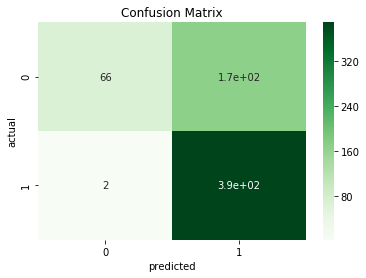

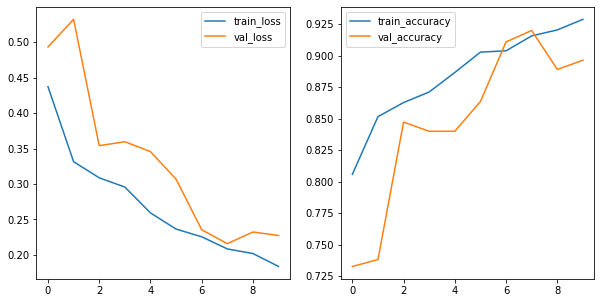

In [30]:
preds3 = model2.predict_classes(data_array)
evaluation(class_list, preds3)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

### Fine Tuning

In [31]:
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))

# Fine tune beginning with this layer
fine_tune_at = 100

# Freezing the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [33]:
model2.compile(keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=METRICS)

tuned_history = model2.fit_generator(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

              precision    recall  f1-score   support

      NORMAL       0.97      0.28      0.43       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.64      0.63       624
weighted avg       0.80      0.73      0.67       624

Accurancy:  0.7259615384615384


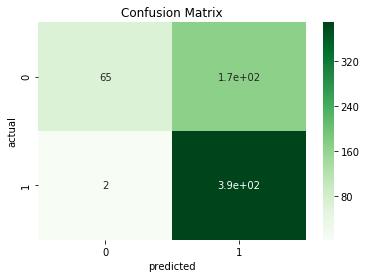

20/20 [==============================] - 9s 442ms/step - loss: 7.3452 - accuracy: 0.7260 - precision: 0.6966 - recall: 0.9949


[('loss', 7.34515905380249),
 ('accuracy', 0.7259615659713745),
 ('precision', 0.6965888738632202),
 ('recall', 0.9948717951774597)]

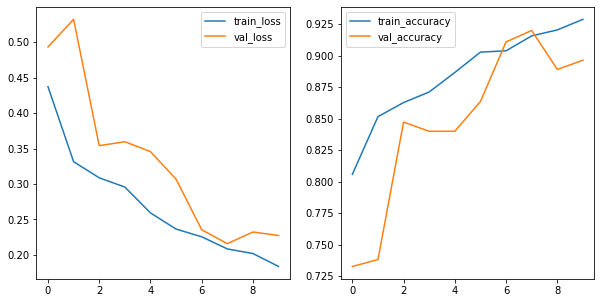

In [35]:
preds3_2 = model2.predict_classes(data_array)
evaluation(class_list, preds3_2)

train_loss = tuned_history.history['loss']
train_acc = tuned_history.history['accuracy']
val_loss = tuned_history.history['val_loss']
val_acc = tuned_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model2.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model2.metrics_names, acc))

In [26]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [38]:
base_model2 = MobileNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model2.trainable=False

base_model2.layers[-1].get_config()

{'name': 'out_relu',
 'trainable': False,
 'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32)}

In [39]:
base_model2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [40]:
model3 = Sequential([base_model2,
                    keras.layers.GlobalAveragePooling2D(),
                    keras.layers.Dense(50, activation='relu'),
                    keras.layers.Dense(1, activation='sigmoid')])

model3.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = train_data.n // batch_size

history_mnv = model3.fit(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

              precision    recall  f1-score   support

      NORMAL       0.97      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.83      0.82       624

Accurancy:  0.8285256410256411


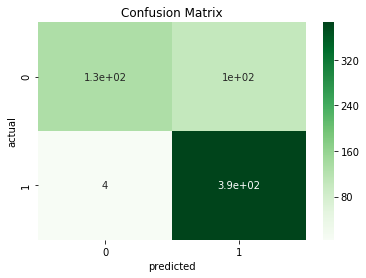

20/20 [==============================] - 6s 322ms/step - loss: 0.8630 - accuracy: 0.8285 - precision: 0.7894 - recall: 0.9897


[('loss', 0.8629642128944397),
 ('accuracy', 0.8285256624221802),
 ('precision', 0.7893660664558411),
 ('recall', 0.9897435903549194)]

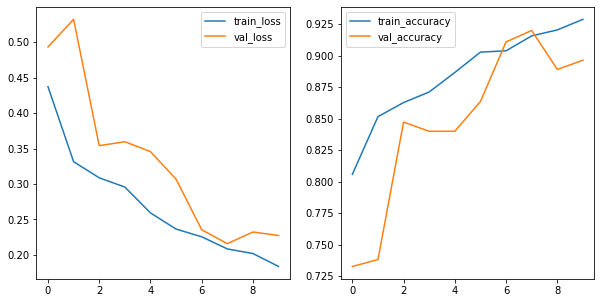

In [42]:
preds4 = model3.predict_classes(data_array)
evaluation(class_list, preds4)

train_loss = history_mnv.history['loss']
train_acc = history_mnv.history['accuracy']
val_loss = history_mnv.history['val_loss']
val_acc = history_mnv.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model3.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model3.metrics_names, acc))

### InceptionV3

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
input_shape = Input(shape=(224,224,3))

base_model3 = InceptionV3(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model3.trainable=False

base_model3.layers[-1].get_config()

87916544/87910968 [==============================] - 8s 0us/step


{'name': 'mixed10', 'trainable': False, 'dtype': 'float32', 'axis': 3}

In [6]:
base_model3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [52]:
image_size=100
batch_size=32

model4 = Sequential([base_model3,
                    keras.layers.GlobalAveragePooling2D(),
                    keras.layers.Dense(50, activation='relu'),
                    keras.layers.Dense(1, activation='sigmoid')])

model4.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20

steps_per_epoch = train_data.n // batch_size

history_mnv = model4.fit(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

Epoch 1/20
146/146 [==============================] - 27s 184ms/step - loss: 0.2389 - accuracy: 0.9028 - precision: 0.9635 - recall: 0.9704 - val_loss: 0.3091 - val_accuracy: 0.8945 - val_precision: 0.8641 - val_recall: 0.9854
Epoch 2/20
146/146 [==============================] - 28s 190ms/step - loss: 0.1514 - accuracy: 0.9390 - precision: 0.9555 - recall: 0.9642 - val_loss: 0.1783 - val_accuracy: 0.9309 - val_precision: 0.9270 - val_recall: 0.9649
Epoch 3/20
146/146 [==============================] - 28s 192ms/step - loss: 0.1319 - accuracy: 0.9503 - precision: 0.9641 - recall: 0.9704 - val_loss: 0.1793 - val_accuracy: 0.9327 - val_precision: 0.9525 - val_recall: 0.9386
Epoch 4/20
146/146 [==============================] - 28s 190ms/step - loss: 0.1150 - accuracy: 0.9572 - precision: 0.9719 - recall: 0.9716 - val_loss: 0.1841 - val_accuracy: 0.9218 - val_precision: 0.9359 - val_recall: 0.9386
Epoch 5/20
146/146 [==============================] - 28s 192ms/step - loss: 0.1034 - accura

              precision    recall  f1-score   support

      NORMAL       0.97      0.57      0.72       215
   PNEUMONIA       0.79      0.99      0.88       345

    accuracy                           0.83       560
   macro avg       0.88      0.78      0.80       560
weighted avg       0.86      0.83      0.81       560

Accurancy:  0.8267857142857142


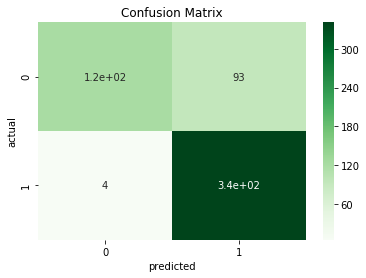

20/20 [==============================] - 6s 288ms/step - loss: 1.3341 - accuracy: 0.8237 - precision: 0.7857 - recall: 0.9872


[('loss', 1.334060788154602),
 ('accuracy', 0.8237179517745972),
 ('precision', 0.7857142686843872),
 ('recall', 0.9871794581413269)]

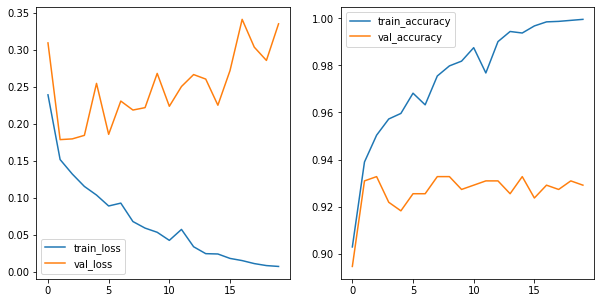

In [54]:
preds5 = model4.predict_classes(data_array)
evaluation(class_list, preds5)

train_loss = history_mnv.history['loss']
train_acc = history_mnv.history['accuracy']
val_loss = history_mnv.history['val_loss']
val_acc = history_mnv.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history_mnv.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history_mnv.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history_mnv.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history_mnv.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model4.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model4.metrics_names, acc))

### InceptionResNetV2

In [13]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [19]:
input_shape = Input(shape=(224,224,3))

base_model4 = InceptionResNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model4.trainable=False

base_model4.layers[-1].get_config()

{'name': 'conv_7b_ac',
 'trainable': False,
 'dtype': 'float32',
 'activation': 'relu'}

In [21]:
image_size=100
batch_size=32

model5 = Sequential([base_model4,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

model5.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 15

steps_per_epoch = train_data.n // batch_size

history_inception_res_v2 = model5.fit(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

Epoch 1/15
146/146 [==============================] - 38s 263ms/step - loss: 0.2261 - accuracy: 0.9187 - precision: 0.9418 - recall: 0.9514 - val_loss: 0.1566 - val_accuracy: 0.9345 - val_precision: 0.9527 - val_recall: 0.9415
Epoch 2/15
146/146 [==============================] - 39s 270ms/step - loss: 0.1601 - accuracy: 0.9390 - precision: 0.9555 - recall: 0.9642 - val_loss: 0.1467 - val_accuracy: 0.9382 - val_precision: 0.9375 - val_recall: 0.9649
Epoch 3/15
146/146 [==============================] - 49s 336ms/step - loss: 0.1401 - accuracy: 0.9463 - precision: 0.9616 - recall: 0.9676 - val_loss: 0.1752 - val_accuracy: 0.9218 - val_precision: 0.9359 - val_recall: 0.9386
Epoch 4/15
146/146 [==============================] - 45s 309ms/step - loss: 0.1150 - accuracy: 0.9561 - precision: 0.9697 - recall: 0.9725 - val_loss: 0.1423 - val_accuracy: 0.9382 - val_precision: 0.9639 - val_recall: 0.9357
Epoch 5/15
146/146 [==============================] - 46s 314ms/step - loss: 0.1121 - accura

              precision    recall  f1-score   support

      NORMAL       0.94      0.63      0.76       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624

Accurancy:  0.8461538461538461


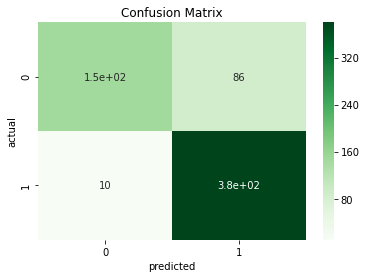

20/20 [==============================] - 7s 334ms/step - loss: 0.8187 - accuracy: 0.8462 - precision: 0.8155 - recall: 0.9744


[('loss', 0.8186874985694885),
 ('accuracy', 0.8461538553237915),
 ('precision', 0.8154506683349609),
 ('recall', 0.9743589758872986)]

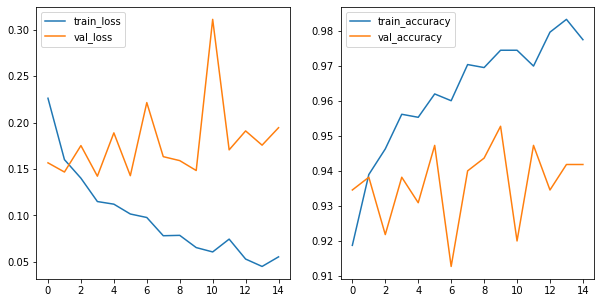

In [25]:
preds6 = model5.predict_classes(data_array)
evaluation(class_list, preds6)

train_loss = history_inception_res_v2.history['loss']
train_acc = history_inception_res_v2.history['accuracy']
val_loss = history_inception_res_v2.history['val_loss']
val_acc = history_inception_res_v2.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history_inception_res_v2.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history_inception_res_v2.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history_inception_res_v2.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history_inception_res_v2.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model5.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model5.metrics_names, acc))

### Fine Tuning InceptionResV2

In [47]:
base_model4.trainable = True
print('Number of layers in the base model: ', len(base_model4.layers))

Number of layers in the base model:  780


### Beginning to tune at layer 730

In [48]:
# Fine tune beginning with this layer
fine_tune_at = 730

# Freezing the layers before the `fine_tune_at` layer
for layer in base_model4.layers[:fine_tune_at]:
    layer.trainable =  False

### RMSprop optimizer

In [53]:
model5.compile(tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=METRICS)

inc_res_2_history = model5.fit_generator(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=450,
                  workers=4,
                  validation_data=val_data)

Epoch 1/450
146/146 [==============================] - 68s 466ms/step - loss: 0.0065 - accuracy: 0.9991 - precision: 0.9982 - recall: 0.9985 - val_loss: 0.1878 - val_accuracy: 0.9600 - val_precision: 0.9624 - val_recall: 0.9737
Epoch 2/450
146/146 [==============================] - 66s 450ms/step - loss: 0.0091 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9991 - val_loss: 0.2210 - val_accuracy: 0.9436 - val_precision: 0.9307 - val_recall: 0.9825
Epoch 3/450
146/146 [==============================] - 64s 440ms/step - loss: 0.0048 - accuracy: 0.9989 - precision: 0.9991 - recall: 0.9994 - val_loss: 0.2343 - val_accuracy: 0.9473 - val_precision: 0.9359 - val_recall: 0.9825
Epoch 4/450
146/146 [==============================] - 62s 427ms/step - loss: 0.0037 - accuracy: 0.9985 - precision: 0.9989 - recall: 0.9991 - val_loss: 0.1985 - val_accuracy: 0.9582 - val_precision: 0.9570 - val_recall: 0.9766
Epoch 5/450
146/146 [==============================] - 65s 448ms/step - loss: 0.0031 - a

              precision    recall  f1-score   support

      NORMAL       0.98      0.54      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.77      0.78       624
weighted avg       0.85      0.82      0.81       624

Accurancy:  0.8221153846153846


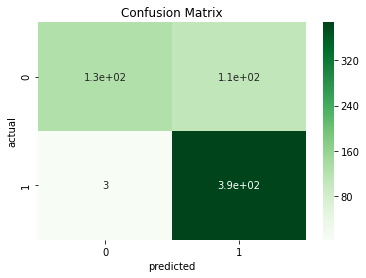

20/20 [==============================] - 7s 334ms/step - loss: 3.9062 - accuracy: 0.8221 - precision: 0.7818 - recall: 0.9923


[('loss', 3.906237840652466),
 ('accuracy', 0.8221153616905212),
 ('precision', 0.7818182110786438),
 ('recall', 0.9923076629638672)]

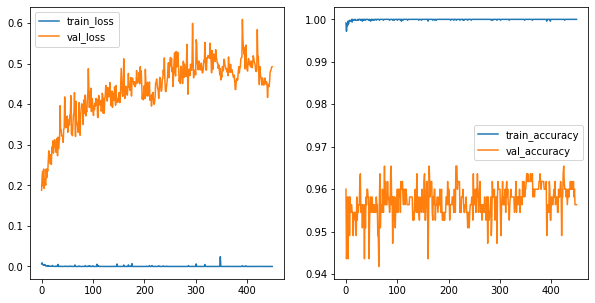

In [60]:
preds6 = model5.predict_classes(data_array)
evaluation(class_list, preds6)

train_loss = inc_res_2_history.history['loss']
train_acc = inc_res_2_history.history['accuracy']
val_loss = inc_res_2_history.history['val_loss']
val_acc = inc_res_2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inc_res_2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inc_res_2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inc_res_2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inc_res_2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model5.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model5.metrics_names, acc))